In [112]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Load census CSVS
neighborhoods = pd.read_csv("https://data.wprdc.org/dataset/95af9f2c-61c8-446b-ae72-852e195684f3/resource/6b09ea3e-7d34-4665-ad0b-798a0efadc29/download/index_pittsburghneighborhoods_blocks_2020.csv")
housing = pd.read_csv("https://data.wprdc.org/dataset/63d09e2c-931c-4c66-86e0-844b84d2a8ad/resource/85ec763a-457e-4025-8263-112baeba0fdb/download/housingrentown.csv")
neighborhood_enrollment = pd.read_csv("https://data.wprdc.org/dataset/27b6eef7-8825-4cc4-8b48-52c17ac80d37/resource/7b0660d1-c812-496d-ab0a-8560902e9e70/download/neighborhood_school_enrollment.csv")
walkability = pd.read_csv("https://data.wprdc.org/dataset/853a077d-0a31-4292-8a1d-5d60b530169b/resource/ab8db07e-09ef-45c4-bad2-f7d32bfc5f26/download/sidewalkstreetratiotract.csv")
groceries = pd.read_csv("https://data.wprdc.org/dataset/690409e3-27e2-47a1-beed-fd600097f951/resource/626357fa-c95d-465f-9a02-3121655b2b78/download/data-conveniencesupermarkets.csv")
zip_codes = pd.read_csv("https://data.wprdc.org/datastore/dump/0c781f02-2bb9-4d0c-9c45-879bde957f34")
zip_codes = zip_codes[zip_codes["name"] == "PITTSBURGH"]

In [113]:
grouped = neighborhoods.groupby(['TRACT'])['Neighborhood'].apply(lambda x: ', '.join(x)).reset_index()
# remove trailing zeros from tracts and convert back to string 
grouped['TRACT'] = grouped['TRACT'].astype(str).apply(lambda x: x[:-2])
neighborhoods = grouped.rename(columns={'TRACT': 'Census Tract'})

# WALKABILITY

In terms of selecting the best neighborhood for livability for a family of four, walkability is a very important role. Walkability has become an indicator of urban livability and quality of life.

In [114]:
# Edit the name so we can merge the neighborhoods dataframe with the walkability dataframe
walkability = walkability.rename(columns={'Tract': 'Census Tract'})
# Edit the census tract so it matches the census tract in the neighborhoods dataframe
walkability['Census Tract'] = walkability['Census Tract'].astype(str).apply(lambda x: x[6:-4])

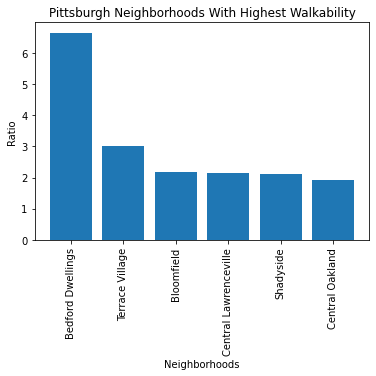

In [115]:
# Merge the neighbhoods and walkability by census tract column
merged = pd.merge(neighborhoods, walkability[['Census Tract', 'Ratio']], on='Census Tract', how='inner')
merged['Neighborhood'] = merged['Neighborhood'].str.split(',').str[0]

# Make sure to only merge when the value isn't null
merged = merged[pd.to_numeric(merged['Ratio'], errors='coerce').notnull()]
merged['Ratio'] = merged['Ratio'].astype(float)
merged = merged.sort_values(by=['Ratio'], ascending=[False]).head(10)

# graph
plt.bar(merged['Neighborhood'][:10], merged['Ratio'][:10])
plt.xticks(rotation=90)
plt.xlabel('Neighborhoods')
plt.ylabel('Ratio')
plt.title('Pittsburgh Neighborhoods With Highest Walkability')
plt.show()

In [116]:
# GROCERIES AND FOOD

In terms of selecting the best neighborhood for livability for a family of four, food plays a huge role

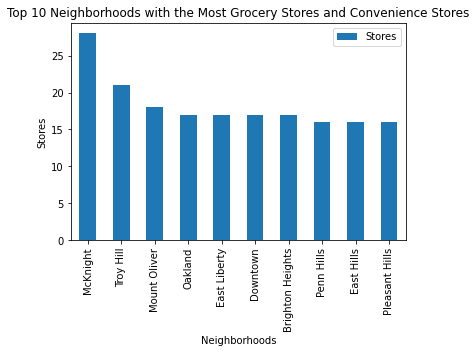

In [117]:
# Only tally food destinations that are labelled under Pittsburgh zipcodes
food = groceries[groceries["Zip"].notnull() == True]
food = food[food["Zip"].astype(int).isin(zip_codes["zip"]) == True]

# The geographical indicator is zip here so we tally the instances of food destinations to the zip code
df = food['Zip'].value_counts().sort_values(ascending=True)


# The previous method causes the zip code to turn into floats, so transform them to ints instead
df = df.reindex(index=df.index.astype(int))

# Sort the values by the top 10
df = df.sort_values(ascending=[False]).head(10)
df = df.to_frame()
# Manually change the zipcode to neighborhood names
df.index = np.array(["McKnight", "Troy Hill", "Mount Oliver", "Oakland", "East Liberty", "Downtown", "Brighton Heights", "Penn Hills", "East Hills", "Pleasant Hills"])
df = df.rename(columns={"Zip": "Stores"})


df.plot(kind='bar', title='Top 10 Neighborhoods with the Most Grocery Stores and Convenience Stores', xlabel='Neighborhoods', ylabel='Stores')
plt.show()

# Conclusion

Isa - When considering what is the best neighborhood by the data, I think it's difficult to say since I often questioned the quality of the data in terms of its organization and aggregation. I was shocked to see that there weren't any viable datasets that specifically mapped zip-codes to neighborhoods for Pittsburgh city proper. I almost successfully created a dataframe that for the mapping by manipulating multiple datasets and merging them based on different features such as geoid, census id, neighborhood names, zip, and global id. However, the zip code dataset's globalid did not match the other datasets that I worked with. As such, I had to manually map zip codes to regions like in the grocery dataframe. The results for the groceries and food metric is confusing since places one could buy food fit between a strict dichotomy of convenience store and supermarket. I considered tightening the results to only consider supermarkets as the store type since most families would not seek gas stations and 711s for groceries; however, this approach excluded small grocery stores. Yet, food deserts such as Oakland and Downtown were included as being a few of the top location to buy food. After our research, it appears that there are extremely loose standards for the WPRDC which can negatively impact people or certain neighborhoods if the data is used incorrectly. People may avoid certain neighborhoods if they see that they are not in a specific list which would then could impact a neighborhood's economy and its inhabitants'  livelihood in the long-run.